## 02. Neural Network Classification with Pytorch

1. Make Classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

# Create circles
X, y = make_circles(
    n_samples,
    noise=0.03,
    random_state = 42
)

In [3]:
~len(X), len(y)

(-1001, 1000)

In [4]:
print(f"First 5 samples of X: {X[:5]}")
print(f"First 5 samples of y: {y[:5]}")

First 5 samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y: [1 1 1 1 0]


In [5]:
# Make dataframe of circle dataset
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
                       "X2": X[:, 1],
                       "label": y})

In [6]:
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


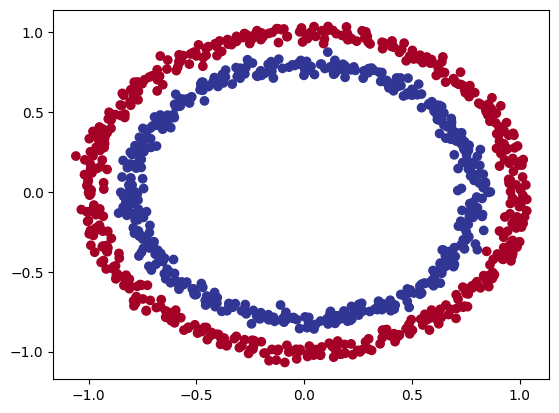

In [7]:
# Visualize visualize and visualize
import matplotlib.pyplot as plt
plt.scatter(x = X[:, 0],
            y = X[:, 1],
            c = y,
            cmap = plt.cm.RdYlBu)

Note: The data we are working with is oftern known as a toy dataset,  a dataset that is small enough to experiment but still sizeable enough to practice the fundamentals.

## 1.1 Check Input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
X[0], X[0].shape

(array([0.75424625, 0.23148074]), (2,))

In [10]:
y[0], y[0].shape

(1, ())

## 1.2 Turn data into tensors and create train and test splits

In [11]:
import torch
print(torch.__version__)

2.2.1+cu121


In [12]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [13]:
X

tensor([[ 0.7542,  0.2315],
        [-0.7562,  0.1533],
        [-0.8154,  0.1733],
        ...,
        [-0.1369, -0.8100],
        [ 0.6704, -0.7675],
        [ 0.2811,  0.9638]])

In [14]:
y[:5]

tensor([1., 1., 1., 1., 0.])

#### Split the data into training and testing set

In [15]:
torch.manual_seed(42)

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [17]:
X_test.shape

torch.Size([200, 2])

## 2. Building the model

Let's build a model to classify our blue and red dots
To do so, we want to:
1. Setup  device agonistic code so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing nn.Module)
3. Define a loss function and optimizer
4. Create a training and test loop

In [18]:
## Import Pytorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Now we whave setup device agnostic code, lets create a model that:

1. subclassess `nn.Module` (almost all models in Pytorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Defines a `forward()` method that outlines the forward pass (or forward computation)
4. Instantiate an instance of our model class and send it to the target `device`

In [19]:
# 1. Construct a model that subclasses the nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. Create 2 nn.Linear Layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5) #takes in two features and upscales to 5 features
    self.layer_2 = nn.Linear(in_features = 5, out_features = 1) # takes  in 5 features from previous layer and outputs a single feature (same shape as y)

  # 3. Define a forward() method that outlines the forward pass
  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # X -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)

In [20]:
model_0.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]], device='cuda:0')),
             ('layer_1.bias',
              tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0')),
             ('layer_2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0')),
             ('layer_2.bias', tensor([-0.2060], device='cuda:0'))])

In [21]:
next(model_0.parameters()).device

device(type='cuda', index=0)

In [22]:
list(model_0.parameters())

[Parameter containing:
 tensor([[ 0.5406,  0.5869],
         [-0.1657,  0.6496],
         [-0.1549,  0.1427],
         [-0.3443,  0.4153],
         [ 0.6233, -0.5188]], device='cuda:0', requires_grad=True),
 Parameter containing:
 tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='cuda:0',
        requires_grad=True),
 Parameter containing:
 tensor([-0.2060], device='cuda:0', requires_grad=True)]

In [23]:
# Replication of the model_0 above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features = 2, out_features = 5),
    nn.Linear(in_features = 5, out_features = 1)
).to(device)

In [24]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

In [25]:
# Make Predictions
with torch.inference_mode():
  untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\n First 10 predictions: \n {untrained_preds[:10]}")
print(f"\n First 10 labels: \n {y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

 First 10 predictions: 
 tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]], device='cuda:0')

 First 10 labels: 
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [26]:
X_test.shape

torch.Size([200, 2])

### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use?

Again... this is problem specific.

For example, for regression you might want MAE or MSE (mean absolute error or mean squared error)

For classification, you might want tbinaru cross entropy or categorical cross entropy (cross entropy).

The loss function measures how `wrong` our models predictions are.

And for optimizer, two of the most common and useful are SGD and Adam. However Pytorch has many built-in options.

* For the loss function we are going to use `torch.nn.BECWithLogitsLoss()`



In [27]:
# Setup the loss function
# loss_fn = nn.BCELoss() # BCELoss = requires inputs to have gone through the sigmoid activation function prior to input to BCELoss
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss = sigmoid activation function built-in i.e. BCELoss + signmoid function. It combines the BCELoss function as well as the sigmoid activation function

optimizer = torch.optim.SGD(params = model_0.parameters(),
                             lr = 0.001)

In [28]:
# Calculate accuracy - out of 100 examples, what percentage does our mnodel get right?
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

## 3. Train Model

To train our model, we are going to need to build a training loop:

1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer step ( gradient descent)

## Going from raw logits -> prediction probabilities -> prediction labels

Our model outputs are going to be raw **logits**.

We can convert these **logits** into prediction probalities by passing them to sime kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to **prediction labels** by either rounding them or taking the `argmax()`.

In [29]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test.to(device))[:5]

In [30]:
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

In [31]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [32]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them.

* y_pred_probs >= 0.5 , y=1 (class 1)
* y_pred_probs < 0.5 , y=0 (class 0)

In [33]:
# Find the predicted labels
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 1., 0., 1.], device='cuda:0')

### 3.2 Building a training and testing loop

In [34]:
torch.manual_seed(43)

# Set the number of epochs
epochs = 1000

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ## Training
  model_0.train()

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss / Accuracy
  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_0.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss
    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% || Test loss: {test_loss:.5f}, Test Accuracy: {test_acc:.5f}")

Epoch: 0 | Loss: 0.69796, Accuracy: 51.88% || Test loss: 0.69462, Test Accuracy: 57.50000
Epoch: 10 | Loss: 0.69793, Accuracy: 52.00% || Test loss: 0.69459, Test Accuracy: 57.50000
Epoch: 20 | Loss: 0.69790, Accuracy: 52.12% || Test loss: 0.69457, Test Accuracy: 57.50000
Epoch: 30 | Loss: 0.69787, Accuracy: 52.25% || Test loss: 0.69455, Test Accuracy: 58.00000
Epoch: 40 | Loss: 0.69784, Accuracy: 52.25% || Test loss: 0.69453, Test Accuracy: 58.00000
Epoch: 50 | Loss: 0.69782, Accuracy: 52.38% || Test loss: 0.69450, Test Accuracy: 58.00000
Epoch: 60 | Loss: 0.69779, Accuracy: 52.38% || Test loss: 0.69448, Test Accuracy: 58.00000
Epoch: 70 | Loss: 0.69776, Accuracy: 52.12% || Test loss: 0.69446, Test Accuracy: 58.00000
Epoch: 80 | Loss: 0.69773, Accuracy: 52.00% || Test loss: 0.69444, Test Accuracy: 58.00000
Epoch: 90 | Loss: 0.69770, Accuracy: 52.00% || Test loss: 0.69442, Test Accuracy: 58.00000
Epoch: 100 | Loss: 0.69768, Accuracy: 52.00% || Test loss: 0.69440, Test Accuracy: 58.00000

## 4. Make predictions and evaluate the model

From the metrics it looks like our model isn't learning anything...

So to inspect it lets make some predictions and make them visual.

In other words, "Visualize, visualize, visualize"

TO do so, we are going to import a function called `plot_decision_boundary()` - https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [35]:
import requests
from pathlib import Path

# Download helper functions from learn pytorch repo (if its not already downloaded)
if Path("./helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

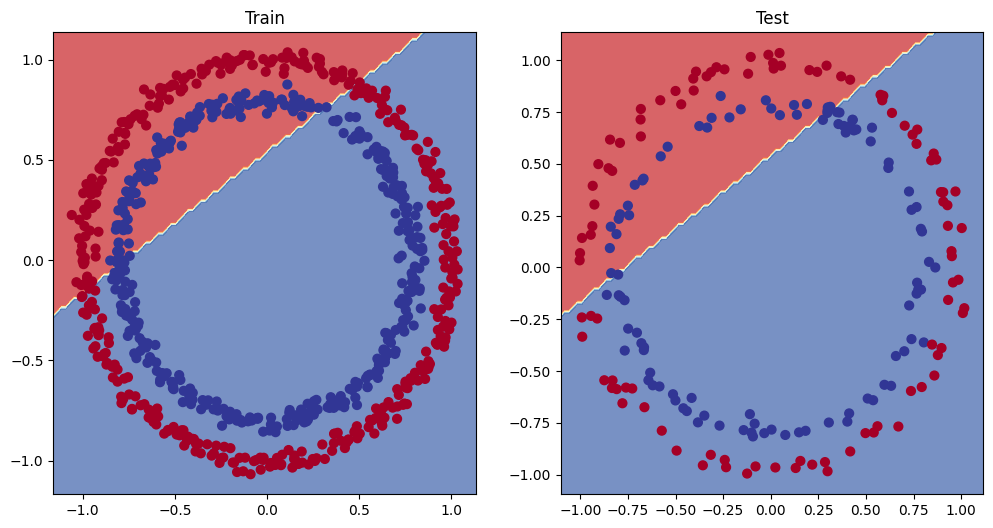

In [36]:
from helper_functions import plot_predictions, plot_decision_boundary
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

## 5. Improving a model (from a model prespective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* CHange the learning rate
* CHange the loss functions

These options are all from a model prespective because they deal directly with the model, rather than the data.

# Improving the model by:

* Adding more hidden units: 5 -> 10
* Increase the number of layers: 2 -> 3
* Increase the number of epochs: 100 -> 1000


In [37]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features=10)
    self.layer_2 = nn.Linear(in_features = 10, out_features=10)
    self.layer_3 = nn.Linear(in_features = 10, out_features=10)
    self.layer_4 = nn.Linear(in_features = 10, out_features=1)

  def forward(self, x):
    # z = self.layer_1(x)
    # z = self.layer_2(z)
    # z = self.layer_3(z)
    # return z
    return self.layer_4(self.layer_3(self.layer_2(self.layer_1(x))))

model_1 = CircleModelV1().to(device)

In [38]:
# define the loss function
loss_fn = nn.BCEWithLogitsLoss()

# create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr=0.01)

In [39]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Build training and evaluation loop
for epoch in range(epochs):
  ## Training
  model_1.train()

  # 1. Forward pass
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

  # 2. Calculate loss / Accuracy
  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backward (backpropagation)
  loss.backward()

  # 5. Optimizer step (gradient descent)
  optimizer.step()

  ### Testing
  model_1.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Calculate the test loss
    test_loss = loss_fn(test_logits,
                        y_test)

    test_acc = accuracy_fn(y_true = y_test,
                           y_pred = test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% || Test loss: {test_loss:.5f}, Test Accuracy: {test_acc:.5f}")

Epoch: 0 | Loss: 0.69543, Accuracy: 53.37% || Test loss: 0.69525, Test Accuracy: 52.50000
Epoch: 100 | Loss: 0.69410, Accuracy: 52.75% || Test loss: 0.69414, Test Accuracy: 54.50000
Epoch: 200 | Loss: 0.69366, Accuracy: 50.75% || Test loss: 0.69385, Test Accuracy: 54.50000
Epoch: 300 | Loss: 0.69349, Accuracy: 49.88% || Test loss: 0.69378, Test Accuracy: 52.00000
Epoch: 400 | Loss: 0.69341, Accuracy: 50.25% || Test loss: 0.69377, Test Accuracy: 50.50000
Epoch: 500 | Loss: 0.69335, Accuracy: 49.38% || Test loss: 0.69377, Test Accuracy: 51.50000
Epoch: 600 | Loss: 0.69330, Accuracy: 49.62% || Test loss: 0.69379, Test Accuracy: 51.50000
Epoch: 700 | Loss: 0.69327, Accuracy: 49.75% || Test loss: 0.69380, Test Accuracy: 49.50000
Epoch: 800 | Loss: 0.69324, Accuracy: 49.75% || Test loss: 0.69382, Test Accuracy: 50.50000
Epoch: 900 | Loss: 0.69321, Accuracy: 50.12% || Test loss: 0.69384, Test Accuracy: 50.50000


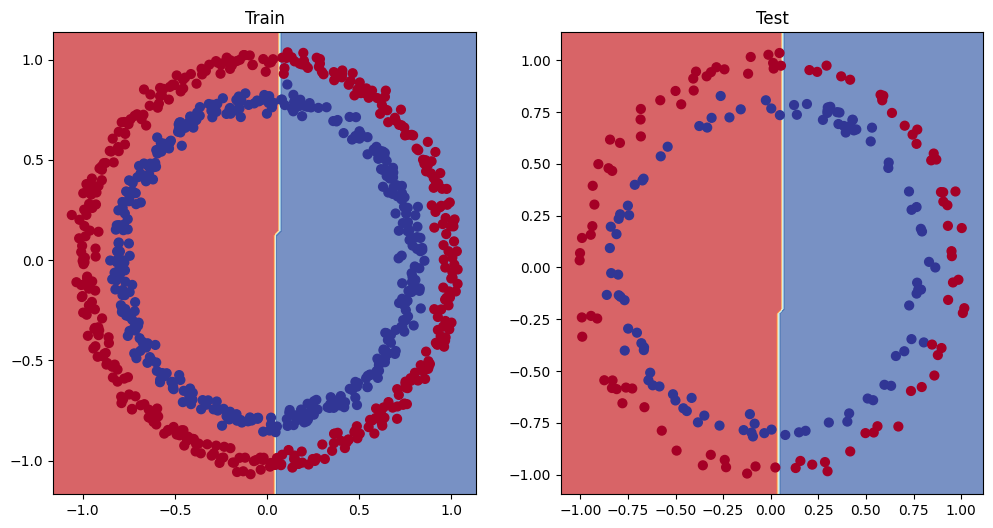

In [40]:
from helper_functions import plot_predictions, plot_decision_boundary
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is to test out a smaller problem.

In [41]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [42]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# CHeck the length of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

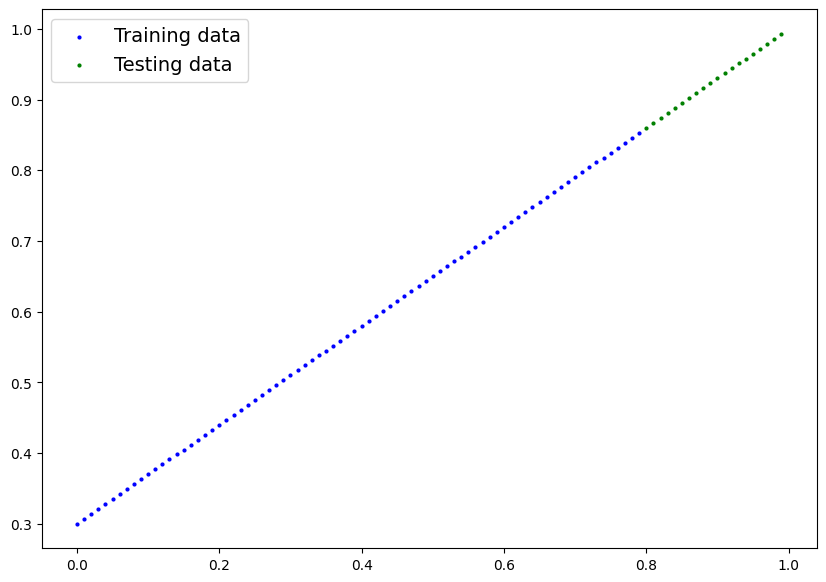

In [43]:
plot_predictions(train_data=X_train_regression,
                 train_labels=y_train_regression,
                 test_data=X_test_regression,
                 test_labels=y_test_regression);

In [44]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[-0.0654, -0.4288],
                      [ 0.5932, -0.2143],
                      [-0.4974, -0.5862],
                      [ 0.1252, -0.6089],
                      [ 0.3451,  0.1845],
                      [ 0.6196, -0.5157],
                      [ 0.0298,  0.0434],
                      [ 0.0504,  0.2950],
                      [-0.1029, -0.3160],
                      [ 0.4816, -0.4881]])),
             ('layer_1.bias',
              tensor([-0.5554,  0.3177, -0.2487,  0.5477, -0.5243,  0.4758,  0.0908, -0.1234,
                       0.5121, -0.3115])),
             ('layer_2.weight',
              tensor([[ 0.0518, -0.1145,  0.1112,  0.1217,  0.2676, -0.1778,  0.0793, -0.0213,
                        0.2272, -0.2144],
                      [-0.1080,  0.2330,  0.1237, -0.0837,  0.0988,  0.1185, -0.0955, -0.2557,
                       -0.2433,  0.1920],
                      [-0.0322,  0.1616, -0.2407,  0.2745,  0.1005, -0.0

In [45]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
)

## 5.2 Adjusting model_1 to fit a straight line

In [46]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1,
              out_features=10),
    nn.Linear(in_features=10,
              out_features=10),
    nn.Linear(in_features=10,
              out_features=1)
).to(device)

In [47]:
## Loss and Optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.01)

In [48]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression = X_train_regression.to(device)
y_train_regression = y_train_regression.to(device)
X_test_regression = X_test_regression.to(device)
y_test_regression = y_test_regression.to(device)

# Training
for epoch in range(epochs):
  model_2.train()
  y_pred = model_2(X_train_regression)
  loss = loss_fn(y_pred, y_train_regression)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Testing
  model_2.eval()
  with torch.inference_mode():
    test_pred = model_2(X_test_regression)
    test_loss = loss_fn(test_pred, y_test_regression)

  # Print out whats happeining
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.75986, Test loss: 0.91103
Epoch: 100 | Loss: 0.02858, Test loss: 0.00081
Epoch: 200 | Loss: 0.02533, Test loss: 0.00209
Epoch: 300 | Loss: 0.02137, Test loss: 0.00305
Epoch: 400 | Loss: 0.01964, Test loss: 0.00341
Epoch: 500 | Loss: 0.01940, Test loss: 0.00387
Epoch: 600 | Loss: 0.01903, Test loss: 0.00379
Epoch: 700 | Loss: 0.01878, Test loss: 0.00381
Epoch: 800 | Loss: 0.01840, Test loss: 0.00329
Epoch: 900 | Loss: 0.01798, Test loss: 0.00360


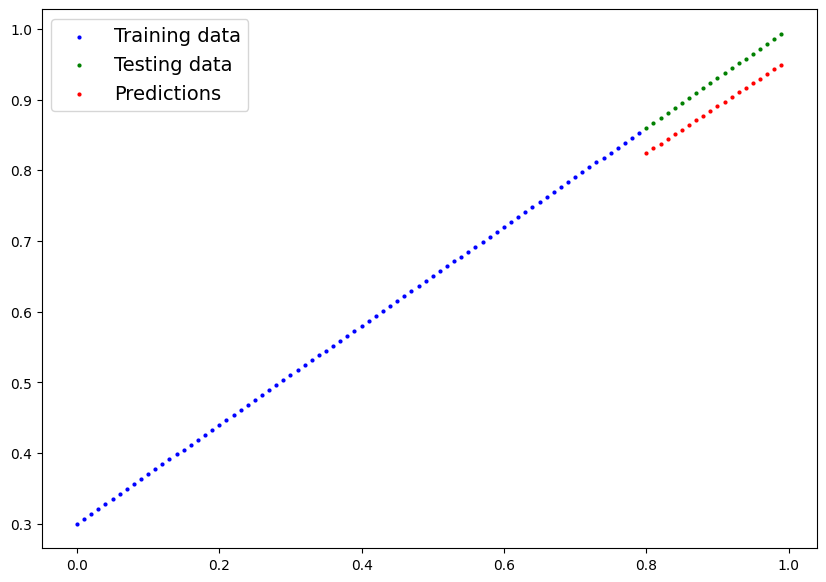

In [52]:
# Turn on evaluation mode
model_2.eval()

# Make Predictions(inference)
with torch.inference_mode():
  y_preds = model_2(X_test_regression)

# Plot data and predictions
plot_predictions(train_data = X_train_regression.cpu(),
                 train_labels = y_train_regression.cpu(),
                 test_data = X_test_regression.cpu(),
                 test_labels = y_test_regression.cpu(),
                 predictions=y_preds.cpu());

Alright, it looks like our model is able to do far better than random guessing on straight lines.

This is a good thing.

It means our model at least has some capacity to learn.

Note: A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.

This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then overfitting (making the model perform too well) on that small example before increasing the amount data or the model size/design to reduce overfitting.

So what could it be?

Let's find out.

## 6. The missing piece: non-linearity

## 6.1 Recreating non-linear data (red and blue circles)
First, let's recreate the data to start off fresh. We'll use the same setup as before.

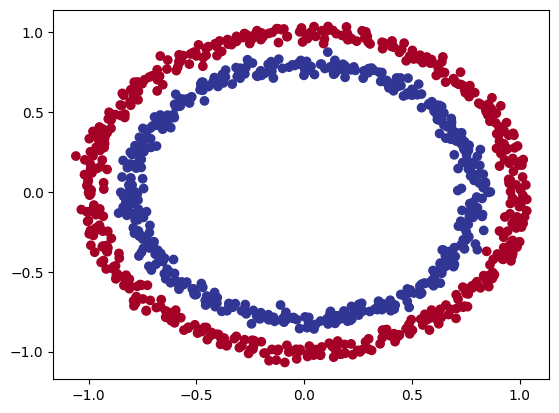

In [53]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

In [54]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Building a model with non-linearity
Now here comes the fun part.

What kind of pattern do you think you could draw with unlimited straight (linear) and non-straight (non-linear) lines?

I bet you could get pretty creative.

So far our neural networks have only been using linear (straight) line functions.

But the data we've been working with is non-linear (circles).

What do you think will happen when we introduce the capability for our model to use non-linear actviation functions?

Well let's see.

PyTorch has a bunch of ready-made non-linear activation functions that do similiar but different things.

One of the most common and best performing is ReLU (rectified linear-unit, torch.nn.ReLU()).

Rather than talk about it, let's put it in our neural network between the hidden layers in the forward pass and see what happens.

In [55]:
# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [56]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

## 6.3 Training a model with non-linearity
You know the drill, model, loss function, optimizer ready to go, let's create a training and testing loop.

In [57]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_3(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69319, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69115, Accuracy: 52.88% | Test Loss: 0.69102, Test Accuracy: 52.50%
Epoch: 200 | Loss: 0.68977, Accuracy: 53.37% | Test Loss: 0.68940, Test Accuracy: 55.00%
Epoch: 300 | Loss: 0.68795, Accuracy: 53.00% | Test Loss: 0.68723, Test Accuracy: 56.00%
Epoch: 400 | Loss: 0.68517, Accuracy: 52.75% | Test Loss: 0.68411, Test Accuracy: 56.50%
Epoch: 500 | Loss: 0.68102, Accuracy: 52.75% | Test Loss: 0.67941, Test Accuracy: 56.50%
Epoch: 600 | Loss: 0.67515, Accuracy: 54.50% | Test Loss: 0.67285, Test Accuracy: 56.00%
Epoch: 700 | Loss: 0.66659, Accuracy: 58.38% | Test Loss: 0.66322, Test Accuracy: 59.00%
Epoch: 800 | Loss: 0.65160, Accuracy: 64.00% | Test Loss: 0.64757, Test Accuracy: 67.50%
Epoch: 900 | Loss: 0.62362, Accuracy: 74.00% | Test Loss: 0.62145, Test Accuracy: 79.00%


## 6.4 Evaluating a model trained with non-linear activation functions
Remember how our circle data is non-linear? Well, let's see how our models predictions look now the model's been trained with non-linear activation functions.

In [58]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

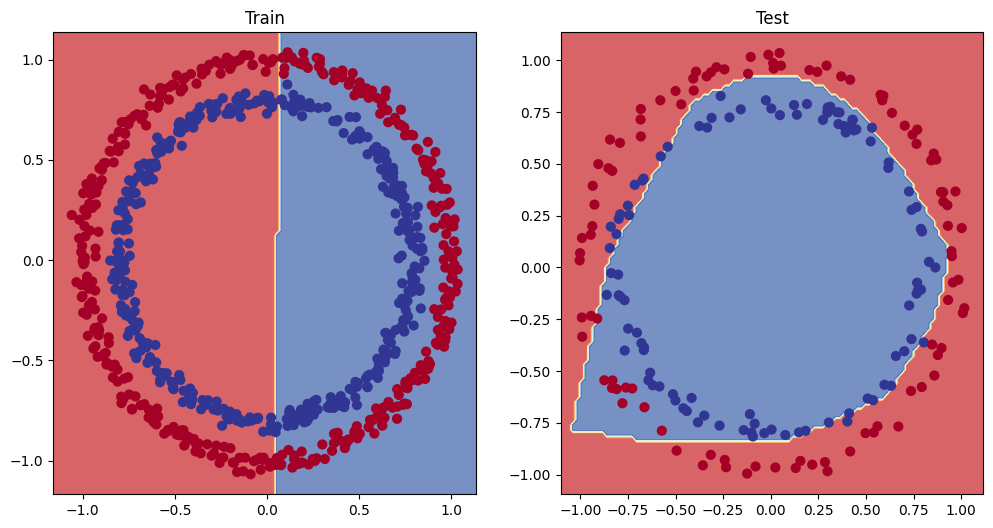

In [59]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

Nice! Not perfect but still far better than before.

Potentially you could try a few tricks to improve the test accuracy of the model? (hint: head back to section 5 for tips on improving the model)

## 7. Replicating non-linear activation functions
We saw before how adding non-linear activation functions to our model can help it to model non-linear data.

Note: Much of the data you'll encounter in the wild is non-linear (or a combination of linear and non-linear). Right now we've been working with dots on a 2D plot. But imagine if you had images of plants you'd like to classify, there's a lot of different plant shapes. Or text from Wikipedia you'd like to summarize, there's lots of different ways words can be put together (linear and non-linear patterns).

But what does a non-linear activation look like?

How about we replicate some and what they do?

Let's start by creating a small amount of data.

In [60]:
# Create a toy tensor (similar to the data going into our model(s))
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

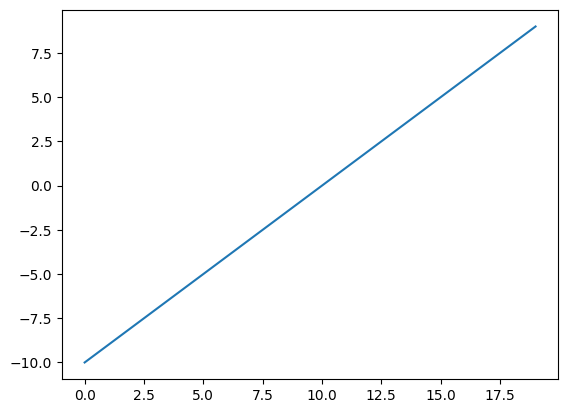

In [61]:
# Visualize the toy tensor
plt.plot(A);

A straight line, nice.

Now let's see how the ReLU activation function influences it.

And instead of using PyTorch's ReLU (torch.nn.ReLU), we'll recreate it ourselves.

The ReLU function turns all negatives to 0 and leaves the positive values as they are.

In [62]:
# Create ReLU function by hand
def relu(x):
  return torch.maximum(torch.tensor(0), x) # inputs must be tensors

# Pass toy tensor through ReLU function
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

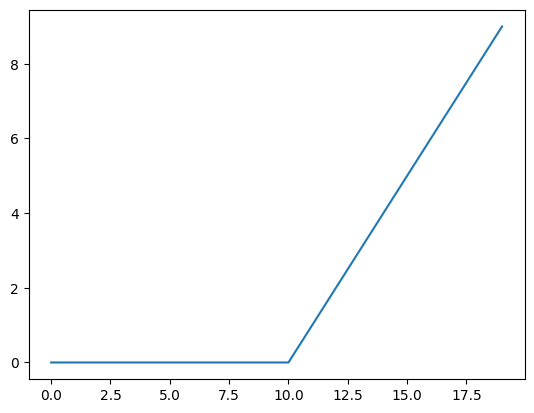

In [63]:
# Plot ReLU activated toy tensor
plt.plot(relu(A));

In [64]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

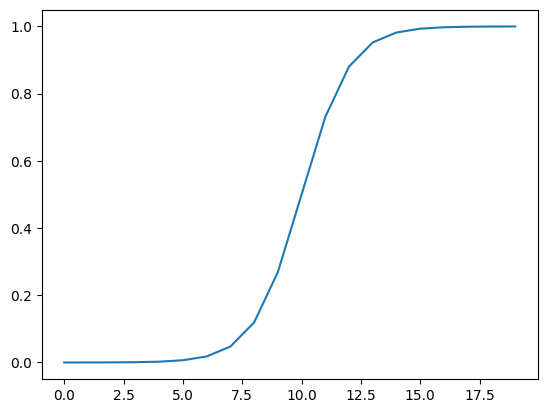

In [65]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(A));

## 8. Putting things together by building a multi-class PyTorch model
We've covered a fair bit.

But now let's put it all together using a multi-class classification problem.

Recall a binary classification problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a multi-class classification problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a chicken).



## 8.1 Creating mutli-class classification data
To begin a multi-class classification problem, let's create some multi-class data.

To do so, we can leverage Scikit-Learn's make_blobs() method.

This method will create however many classes (using the centers parameter) we want.

Specifically, let's do the following:

Create some multi-class data with make_blobs().
Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
Split the data into training and test sets using train_test_split().
Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


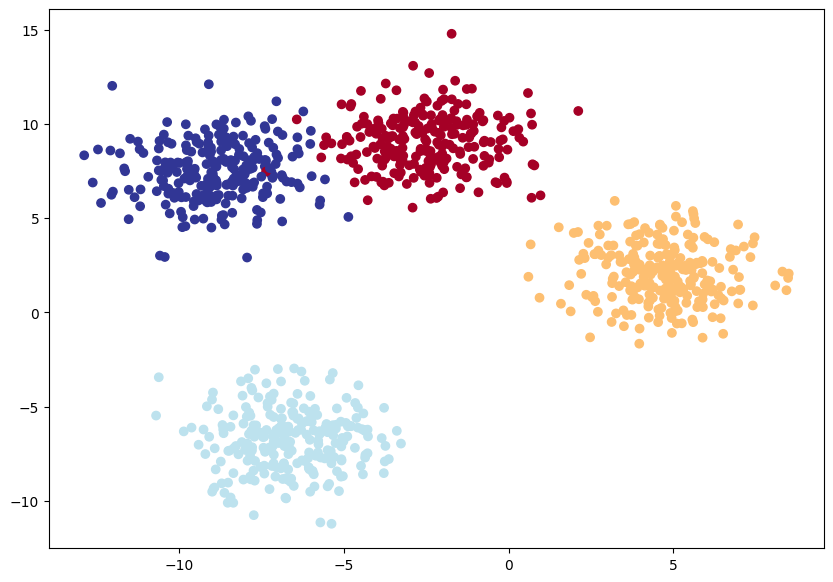

In [66]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

Nice! Looks like we've got some multi-class data ready to go.

Let's build a model to separate the coloured blobs.

Question: Does this dataset need non-linearity? Or could you draw a succession of straight lines to separate it?

## 8.2 Building a multi-class classification model in PyTorch
We've created a few models in PyTorch so far.

You might also be starting to get an idea of how flexible neural networks are.

How about we build one similar to model_3 but this still capable of handling multi-class data?

To do so, let's create a subclass of nn.Module that takes in three hyperparameters:

input_features - the number of X features coming into the model.
output_features - the ideal numbers of output features we'd like (this will be equivalent to NUM_CLASSES or the number of classes in your multi-class classification problem).
hidden_units - the number of hidden neurons we'd like each hidden layer to use.
Since we're putting things together, let's setup some device agnostic code (we don't have to do this again in the same notebook, it's only a reminder).

Then we'll create the model class using the hyperparameters above.

In [67]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [69]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

Excellent! Our multi-class model is ready to go, let's create a loss function and optimizer for it.

## 8.3 Creating a loss function and optimizer for a multi-class PyTorch model
Since we're working on a multi-class classification problem, we'll use the nn.CrossEntropyLoss() method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our model_4 parameters.

In [71]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

## 8.4 Getting prediction probabilities for a multi-class PyTorch model
Alright, we've got a loss function and optimizer ready, and we're ready to train our model but before we do let's do a single forward pass with our model to see if it works.

In [72]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]

tensor([[ 0.6226, -0.4992,  0.3042, -0.2222],
        [ 0.6736, -1.1873,  0.1842, -0.6871],
        [ 0.2130, -0.9997,  0.3891, -1.0923],
        [ 0.4027, -0.7745,  0.4512, -0.8176],
        [ 0.3791, -1.2052,  0.0704, -0.7173]], device='cuda:0',
       grad_fn=<SliceBackward0>)

What's coming out here?

It looks like we get one value per feature of each sample.

Let's check the shape to confirm.

In [73]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

Wonderful, our model is predicting one value for each class that we have.

Do you remember what the raw outputs of our model are called?

Hint: it rhymes with "frog splits" (no animals were harmed in the creation of these materials).

If you guessed logits, you'd be correct.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from logits -> prediction probabilities -> prediction labels just like we did with the binary classification problem?

That's where the softmax activation function comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

If this doesn't make sense, let's see in code.

In [74]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.7111, -0.5330,  0.3307, -0.2327],
        [-0.3420, -1.7850, -0.3224, -1.1384],
        [ 0.1878, -0.8563,  0.3375, -0.9026],
        [ 0.4513, -0.4277,  0.2498, -0.1940],
        [ 0.8922, -0.9492,  0.3245, -0.5287]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.4236, 0.1221, 0.2895, 0.1648],
        [0.3694, 0.0873, 0.3767, 0.1666],
        [0.3509, 0.1235, 0.4076, 0.1179],
        [0.3627, 0.1506, 0.2965, 0.1902],
        [0.5084, 0.0806, 0.2882, 0.1228]], device='cuda:0',
       grad_fn=<SliceBackward0>)


Hmm, what's happened here?

It may still look like the outputs of the softmax function are jumbled numbers (and they are, since our model hasn't been trained and is predicting using random patterns) but there's a very specific thing different about each sample.

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

Let's check.

In [75]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1.0000, device='cuda:0', grad_fn=<SumBackward0>)

These prediction probablities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in y_pred_probs, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using torch.argmax().

In [76]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.4236, 0.1221, 0.2895, 0.1648], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


You can see the output of torch.argmax() returns 3, so for the features (X) of the sample at index 0, the model is predicting that the most likely class value (y) is 3.

Of course, right now this is just random guessing so it's got a 25% chance of being right (since there's four classes). But we can improve those chances by training the model.

Note: To summarize the above, a model's raw output is referred to as logits.

For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (torch.softmax).

The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

## 8.5 Creating a training and testing loop for a multi-class PyTorch model
Alright, now we've got all of the preparation steps out of the way, let's write a training and testing loop to improve and evaluate our model.

We've done many of these steps before so much of this will be practice.

The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).

Let's train the model for epochs=100 and evaluate it every 10 epochs.

In [77]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.37484, Acc: 49.38% | Test Loss: 1.14556, Test Acc: 76.50%
Epoch: 10 | Loss: 0.66512, Acc: 72.62% | Test Loss: 0.55919, Test Acc: 79.50%
Epoch: 20 | Loss: 0.50131, Acc: 73.12% | Test Loss: 0.41657, Test Acc: 79.00%
Epoch: 30 | Loss: 0.40910, Acc: 80.75% | Test Loss: 0.33745, Test Acc: 84.00%
Epoch: 40 | Loss: 0.33915, Acc: 87.00% | Test Loss: 0.27875, Test Acc: 90.00%
Epoch: 50 | Loss: 0.26286, Acc: 94.88% | Test Loss: 0.21292, Test Acc: 97.00%
Epoch: 60 | Loss: 0.16298, Acc: 98.38% | Test Loss: 0.13005, Test Acc: 99.00%
Epoch: 70 | Loss: 0.09657, Acc: 98.88% | Test Loss: 0.07737, Test Acc: 99.00%
Epoch: 80 | Loss: 0.06813, Acc: 98.88% | Test Loss: 0.05467, Test Acc: 99.00%
Epoch: 90 | Loss: 0.05487, Acc: 98.88% | Test Loss: 0.04399, Test Acc: 99.00%


## 8.6 Making and evaluating predictions with a PyTorch multi-class model
It looks like our trained model is performaning pretty well.

But to make sure of this, let's make some predictions and visualize them.

In [79]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 0.9988,  4.9449, -2.3442, -0.9238],
        [-1.5220, -6.5819, -8.1528,  3.7136],
        [-3.8011, -3.0290,  5.1995, -2.5184],
        [-0.1409,  3.5777, -1.3611, -0.3910],
        [ 6.0244,  2.6601, -5.1481, -1.9724],
        [-2.2247, -8.1695, -9.5303,  4.6788],
        [-3.5962, -2.8465,  4.8426, -2.3268],
        [ 5.0665, -0.2089, -6.0726, -0.7773],
        [-4.3616, -3.6295,  6.2815, -3.1414],
        [ 5.3172,  0.8219, -5.6387, -1.1980]], device='cuda:0')

Alright, looks like our model's predictions are still in logit form.

Though to evaluate them, they'll have to be in the same form as our labels (y_blob_test) which are in integer form.

Let's convert our model's prediction logits to prediction probabilities (using torch.softmax()) then to prediction labels (by taking the argmax() of each sample).

Note: It's possible to skip the torch.softmax() function and go straight from predicted logits -> predicted labels by calling torch.argmax() directly on the logits.

For example, y_preds = torch.argmax(y_logits, dim=1), this saves a computation step (no torch.softmax()) but results in no prediction probabilities being available to use.

In [80]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
Test accuracy: 99.0%


Nice! Our model predictions are now in the same form as our test labels.

Let's visualize them with plot_decision_boundary(), remember because our data is on the GPU, we'll have to move it to the CPU for use with matplotlib (plot_decision_boundary() does this automatically for us).

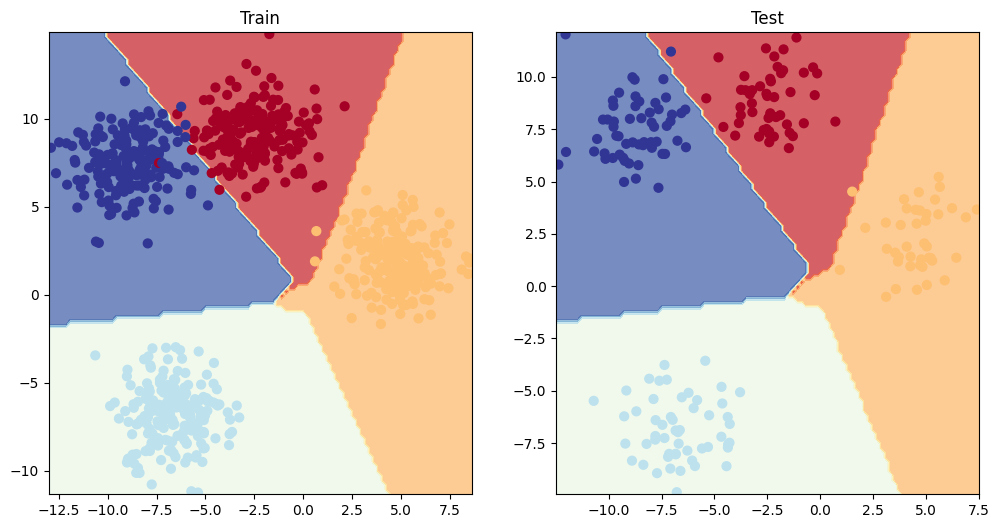

In [81]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

9. More classification evaluation metrics
So far we've only covered a couple of ways of evaluating a classification model (accuracy, loss and visualizing predictions).

These are some of the most common methods you'll come across and are a good starting point.

However, you may want to evaluate your classification model using more metrics such as the following:

Metric name/Evaluation method	Defintion	Code
Accuracy	Out of 100 predictions, how many does your model get correct? E.g. 95% accuracy means it gets 95/100 predictions correct.	torchmetrics.Accuracy() or sklearn.metrics.accuracy_score()
Precision	Proportion of true positives over total number of samples. Higher precision leads to less false positives (model predicts 1 when it should've been 0).	torchmetrics.Precision() or sklearn.metrics.precision_score()
Recall	Proportion of true positives over total number of true positives and false negatives (model predicts 0 when it should've been 1). Higher recall leads to less false negatives.	torchmetrics.Recall() or sklearn.metrics.recall_score()
F1-score	Combines precision and recall into one metric. 1 is best, 0 is worst.	torchmetrics.F1Score() or sklearn.metrics.f1_score()
Confusion matrix	Compares the predicted values with the true values in a tabular way, if 100% correct, all values in the matrix will be top left to bottom right (diagnol line).	torchmetrics.ConfusionMatrix or sklearn.metrics.plot_confusion_matrix()
Classification report	Collection of some of the main classification metrics such as precision, recall and f1-score.	sklearn.metrics.classification_report()
Scikit-Learn (a popular and world-class machine learning library) has many implementations of the above metrics and you're looking for a PyTorch-like version, check out TorchMetrics, especially the TorchMetrics classification section.

Let's try the torchmetrics.Accuracy metric out.

In [82]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

tensor(0.9900, device='cuda:0')